### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

# Training Data
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G2vAU07RlFc9_bTMY9WSAlx9GdsS6ALY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1G2vAU07RlFc9_bTMY9WSAlx9GdsS6ALY" -O training.zip && rm -rf /tmp/cookies.txt
# !unzip training
# Testing Data
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jnbxTisefsT6pTnrVkigngG_OUdPUot_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jnbxTisefsT6pTnrVkigngG_OUdPUot_" -O test.zip && rm -rf /tmp/cookies.txt  
# !unzip test

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    # points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
imgs_train = np.expand_dims(imgs_train, axis=3)
validation = imgs_train.shape[0]//20
imgs_val = imgs_train[:validation]
imgs_train = imgs_train[validation:]
points_val = points_train[:validation]
points_train = points_train[validation:]
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2033, 96, 96, 1) 
關鍵點資料: (2033, 30)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.models import Model

Using TensorFlow backend.
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yanroo/anaconda3/

In [6]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # Input dimensions: (None, 96, 96, 1)
    model.add(Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 96, 96, 32)
    model.add(Conv2D(32, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Input dimensions: (None, 48, 48, 32)
    model.add(Conv2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 48, 48, 64)
    model.add(Conv2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Input dimensions: (None, 24, 24, 64)
    model.add(Conv2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 24, 24, 96)
    model.add(Conv2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Input dimensions: (None, 12, 12, 96)
    model.add(Conv2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 12, 12, 128)
    model.add(Conv2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Input dimensions: (None, 6, 6, 128)
    model.add(Conv2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 6, 6, 256)
    model.add(Conv2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Input dimensions: (None, 3, 3, 256)
    model.add(Conv2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 3, 3, 512)
    model.add(Conv2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    # Input dimensions: (None, 3, 3, 512)
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30))
    
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [9]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen=ImageDataGenerator()

train_generator=train_datagen.flow(imgs_train, 
                                   points_train,
                                   batch_size=64,
                                   shuffle=True)

val_datagen=ImageDataGenerator()
val_generator = val_datagen.flow(imgs_val, points_val, batch_size=64)


hist_model = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs=50, verbose=1, workers=1,
                              use_multiprocessing=False, callbacks=[checkpoint, hist])


# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Epoch 1/50
32/32 [==============================] - 4s 139ms/step - loss: 262.7939 - val_loss: 438.8963

Epoch 00001: val_loss improved from inf to 438.89630, saving model to best_weights.h5
Epoch 2/50
32/32 [==============================] - 1s 46ms/step - loss: 28.3010 - val_loss: 33.6792

Epoch 00002: val_loss improved from 438.89630 to 33.67921, saving model to best_weights.h5
Epoch 3/50
32/32 [==============================] - 1s 46ms/step - loss: 24.4770 - val_loss: 20.9809

Epoch 00003: val_loss improved from 33.67921 to 20.98090, saving model to best_weights.h5
Epoch 4/50
32/32 [==============================] - 1s 46ms/step - loss: 21.1083 - val_loss: 6.8235

Epoch 00004: val_loss improved from 20.98090 to 6.82352, saving model to best_weights.h5
Epoch 5/50
32/32 [==============================] - 1s 46ms/step - loss: 18.6317 - val_loss: 8.1580

Epoch 00005: val_loss did not improve from 6.82352
Epoch 6/50
32/32 [==============================] - 1s 46ms/step - loss: 17.8237 -

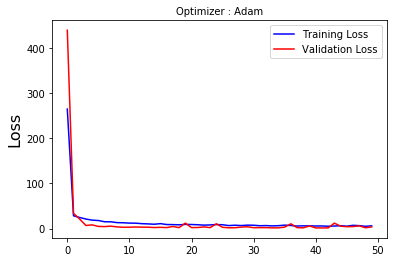

In [10]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [11]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [12]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    for i in range(0,30,2):
        plt.scatter(points[i], points[i+1], color='red')

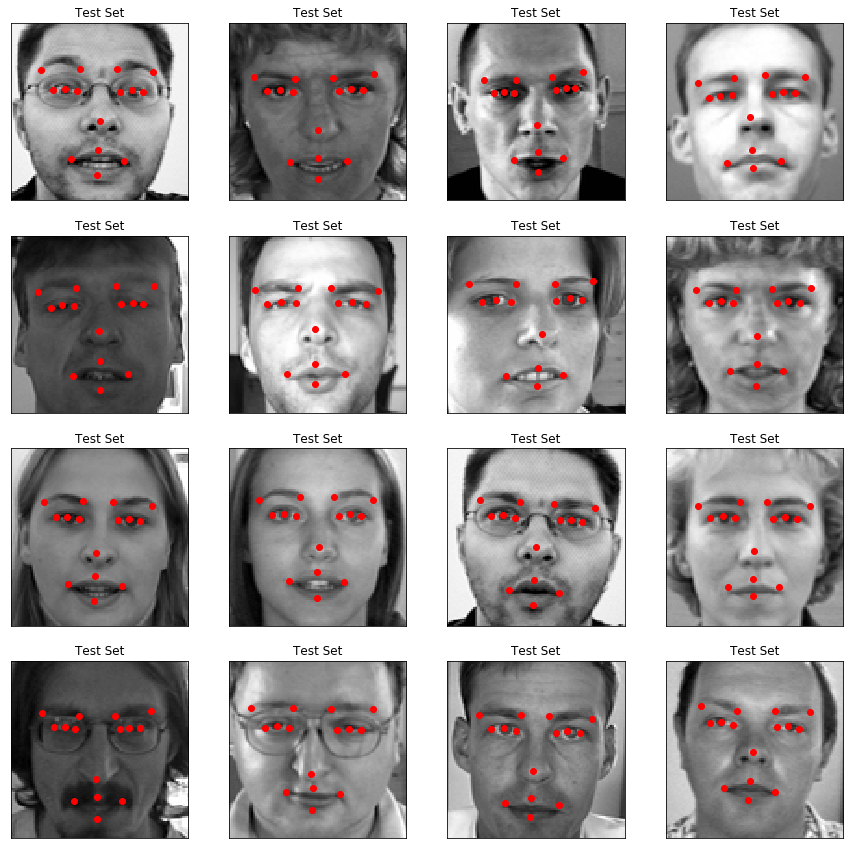

In [13]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]), "Test Set")

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




In [14]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
def point2tuple(keypoints):
    a = []
    for idx in range(0, len(keypoints), 2):
        a.append((keypoints[idx], keypoints[idx+1]))
    return a

In [16]:
def trans(x):
    tmp = np.copy(x)
    x[0], x[1] = tmp[1], tmp[0] 
    x[2:4], x[4:6] = tmp[4:6], tmp[2:4]
    x[6:8], x[8:10] = tmp[8:10], tmp[6:8]
    x[11], x[12] = tmp[12], tmp[11]
    
    return x

#### imgaug Augmentation

In [17]:
# import imgaug as ia
# import imgaug.augmenters as iaa
# from imgaug.augmentables import Keypoint, KeypointsOnImage

# seq = iaa.Sequential([iaa.Fliplr(1)], random_order=True)


# def flip_augmentation(images, keypoints):
    
#     flip_images = []
#     flip_keypoints = []
    
#     for idx in range(len(imgs_train)):
#         image = imgs_train[idx]
#         keypoints = KeypointsOnImage.from_xy_array(points_train[idx].reshape(-1,2), (96,96))
#         image_aug, kps_aug = seq(image=image, keypoints=keypoints)

        
#         flip_images.append(image_aug.reshape(96,96,1))
#         flip_keypoints.append(trans(KeypointsOnImage.to_xy_array(kps_aug)).reshape(30,))
        
#     return np.reshape(flip_images,(-1,96,96,1)), flip_keypoints

# flip_train_images, flip_train_keypoints = flip_augmentation(imgs_train, points_train)
# print("\nShape of flip_train_images: {}".format(np.shape(flip_train_images)))
# print("Shape of flip_train_keypoints: {}\n".format(np.shape(flip_train_keypoints)))
# imgs_train = np.concatenate((imgs_train, flip_train_images))
# points_train = np.concatenate((points_train, flip_train_keypoints))
# print("Total training images:", imgs_train.shape[0])
# print("Total training keypoints:", points_train.shape[0])

# # sample_image_index = 20
# # fig, axis = plt.subplots()
# # plot_sample(scale_train_images[sample_image_index], scale_train_keypoints[sample_image_index], axis, "Scale Augmentation")

# fig = plt.figure(figsize=(30,30))
# for i in range(0,32,2):
#     ax = fig.add_subplot(8, 4, i + 1, xticks=[], yticks=[])
#     plot_keypoints(np.squeeze(flip_train_images[i]), np.squeeze(flip_train_keypoints[i]), "Horizontal Flip")
#     ax = fig.add_subplot(8, 4, i + 2, xticks=[], yticks=[])
#     plot_keypoints(np.squeeze(imgs_train[i]), np.squeeze(points_train[i]), "Original")

#### albumentation Augmentation


Shape of flip_train_images: (2033, 96, 96, 1)
Shape of flip_train_keypoints: (2033, 30)

Total training images: 4066
Total training keypoints: 4066


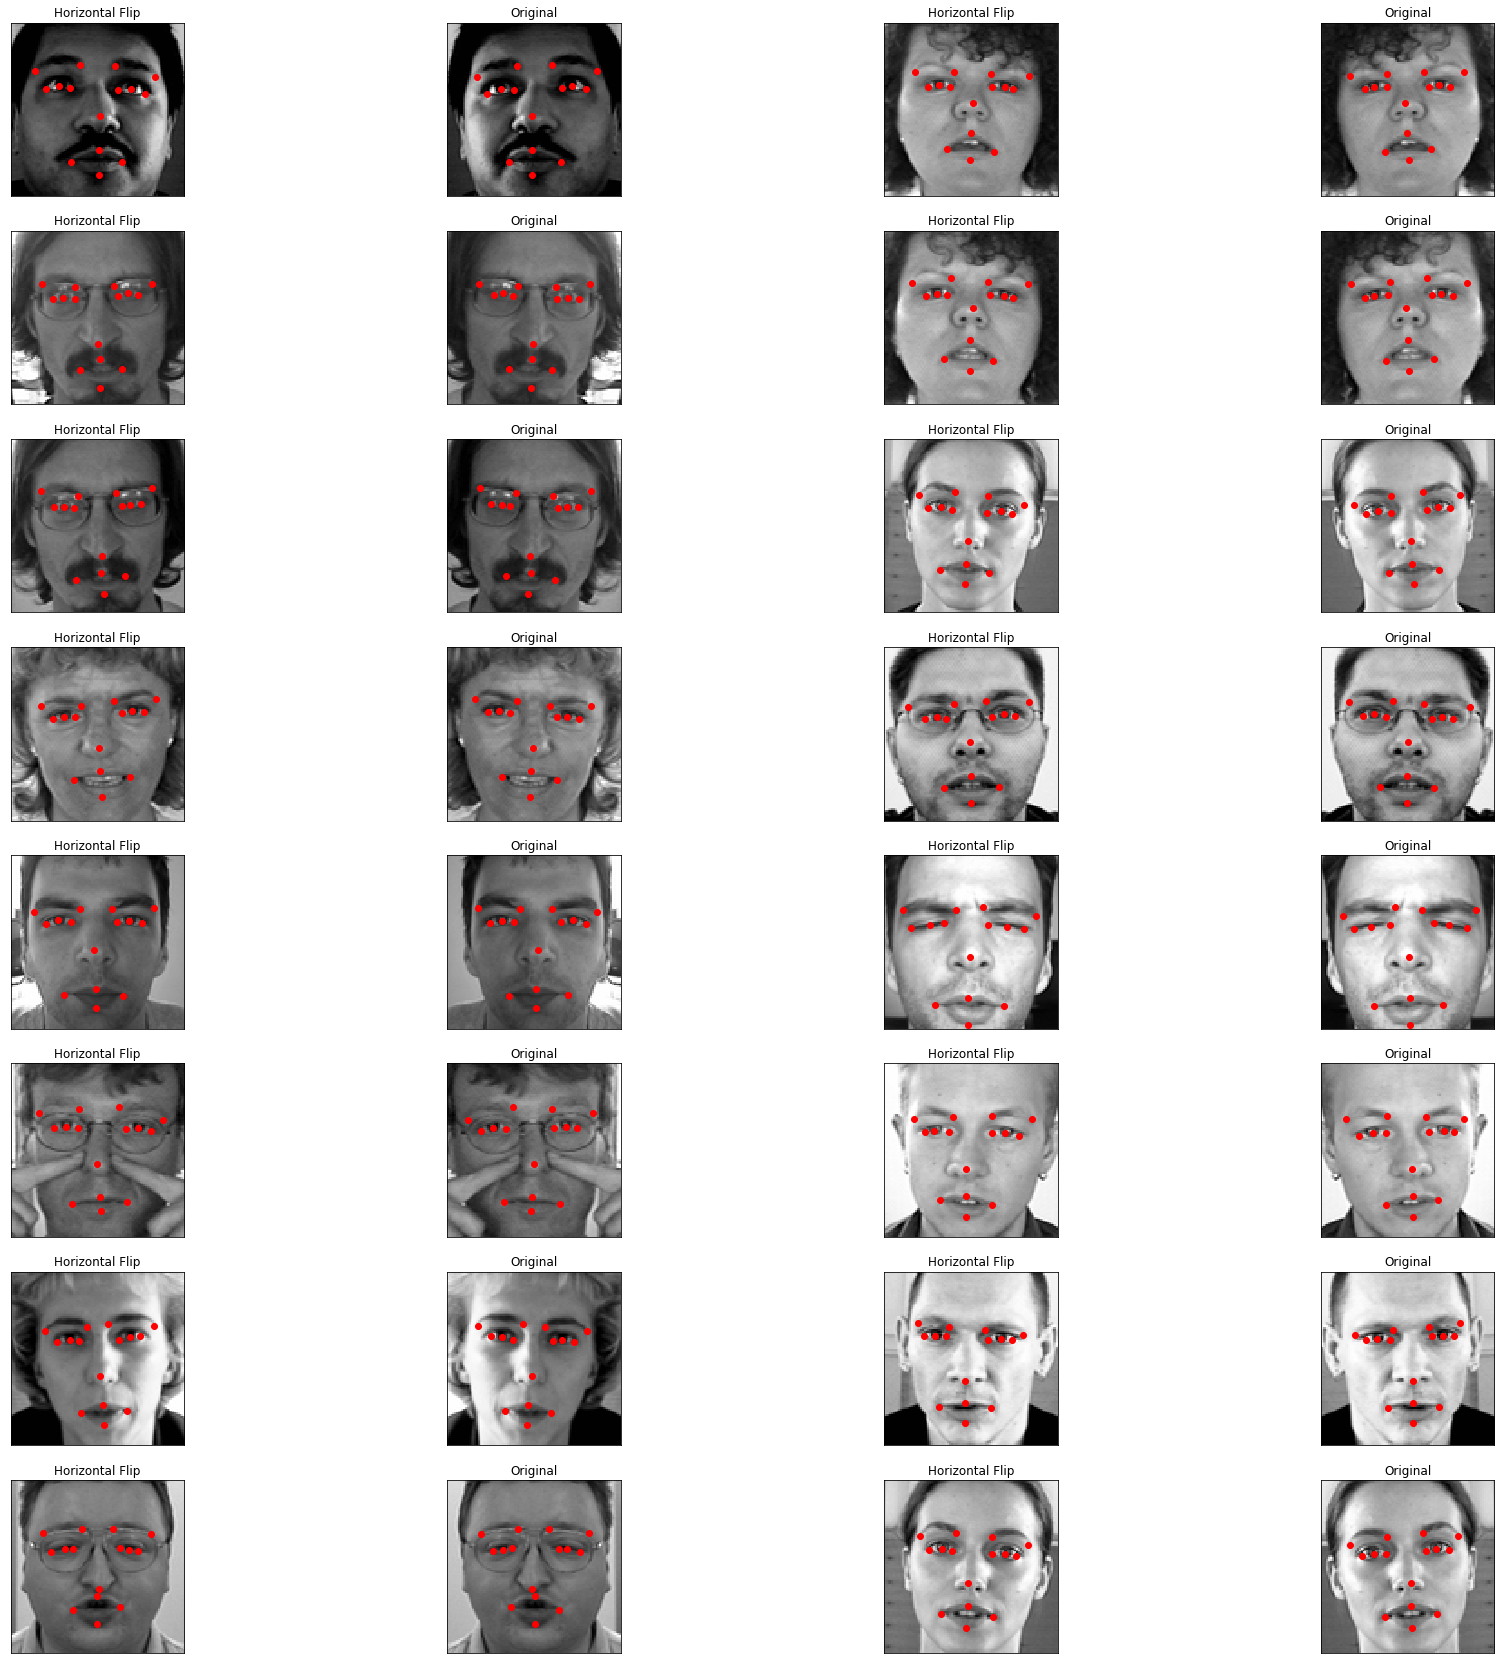

In [18]:
import albumentations as albu

def create_transformer(transformations, image, points):
    return albu.Compose(transformations, p=1, 
                        keypoint_params=albu.KeypointParams(format='xy'))(image=image, keypoints=points)

def flip_augmentation(images, keypoints):
    
    flip_images = []
    flip_keypoints = []
    
    for idx in range(len(imgs_train)):
        image = imgs_train[idx]
        keypoints = point2tuple(points_train[idx])
        transformed = create_transformer([albu.HorizontalFlip(p=1)],
                                         image.reshape(96,96), keypoints)
        
        if len(transformed['keypoints']) == 15:
            flip_images.append(transformed['image'].reshape(96,96,1))
            flip_keypoints.append(trans(np.array(transformed['keypoints'])).reshape(30,))
        
    return np.reshape(flip_images,(-1,96,96,1)), flip_keypoints
    
flip_train_images, flip_train_keypoints = flip_augmentation(imgs_train, points_train)
print("\nShape of flip_train_images: {}".format(np.shape(flip_train_images)))
print("Shape of flip_train_keypoints: {}\n".format(np.shape(flip_train_keypoints)))
imgs_train = np.concatenate((imgs_train, flip_train_images))
points_train = np.concatenate((points_train, flip_train_keypoints))
print("Total training images:", imgs_train.shape[0])
print("Total training keypoints:", points_train.shape[0])

# sample_image_index = 20
# fig, axis = plt.subplots()
# plot_sample(scale_train_images[sample_image_index], scale_train_keypoints[sample_image_index], axis, "Scale Augmentation")

fig = plt.figure(figsize=(30,30))
for i in range(0,32,2):
    ax = fig.add_subplot(8, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(np.squeeze(flip_train_images[i]), np.squeeze(flip_train_keypoints[i]), "Horizontal Flip")
    ax = fig.add_subplot(8, 4, i + 2, xticks=[], yticks=[])
    plot_keypoints(np.squeeze(imgs_train[i]), np.squeeze(points_train[i]), "Original")


In [19]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen=ImageDataGenerator()

train_generator=train_datagen.flow(imgs_train, 
                                   points_train,
                                   batch_size=64,
                                   shuffle=True)

val_datagen=ImageDataGenerator()
val_generator = val_datagen.flow(imgs_val, points_val, batch_size=64)


aug_hist_model = model_with_augment.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs=50, verbose=1, workers=1,
                              use_multiprocessing=False, callbacks=[checkpoint, hist])

# save the model weights
model_with_augment.save_weights('aug_weights.h5')
# save the model
model_with_augment.save('aug_model.h5')

Epoch 1/50
64/64 [==============================] - 5s 81ms/step - loss: 140.4057 - val_loss: 39.9756

Epoch 00001: val_loss did not improve from 1.43793
Epoch 2/50
64/64 [==============================] - 3s 46ms/step - loss: 21.7503 - val_loss: 8.2996

Epoch 00002: val_loss did not improve from 1.43793
Epoch 3/50
64/64 [==============================] - 3s 46ms/step - loss: 17.5077 - val_loss: 4.1152

Epoch 00003: val_loss did not improve from 1.43793
Epoch 4/50
64/64 [==============================] - 3s 46ms/step - loss: 14.5325 - val_loss: 4.3064

Epoch 00004: val_loss did not improve from 1.43793
Epoch 5/50
64/64 [==============================] - 3s 46ms/step - loss: 13.4875 - val_loss: 5.2875

Epoch 00005: val_loss did not improve from 1.43793
Epoch 6/50
64/64 [==============================] - 3s 46ms/step - loss: 11.3115 - val_loss: 3.1772

Epoch 00006: val_loss did not improve from 1.43793
Epoch 7/50
64/64 [==============================] - 3s 46ms/step - loss: 12.3305 - val

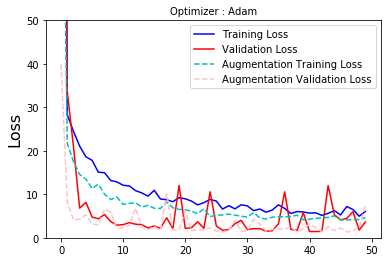

In [20]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,50])
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.plot(aug_hist_model.history['loss'], '--', color='c', label='Augmentation Training Loss')
plt.plot(aug_hist_model.history['val_loss'], '--', color='pink', label='Augmentation Validation Loss')
plt.legend(loc='upper right')

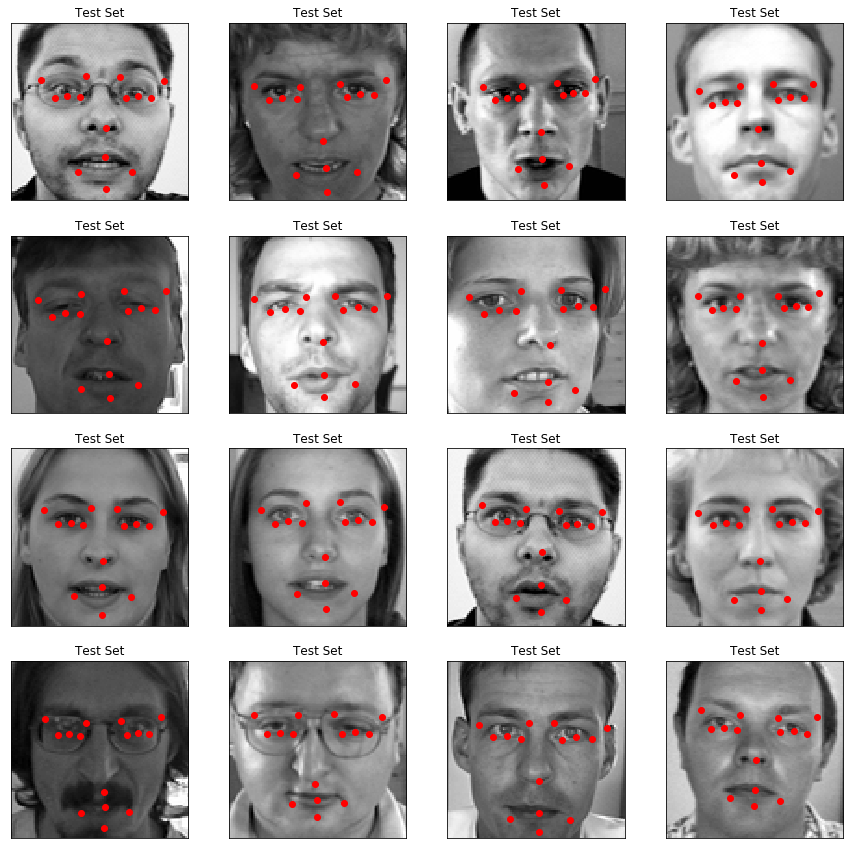

In [21]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]), "Test Set")